# <center>  <font style="color:rgb(134,19,348)">Super Resolution With DNN</font> </center>






Today with deep learning methods we can actually enhance many low resolution images to a high resolution version, sometimes even as high as 8x resolution. This means you can take a 224x224 image and make it 1792x1792 without any loss in quality. This technique is called Super Resolution

The Super Res model we’ll be using is called “Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network”  by Wenzhe Shi et al, 2016. Although this does not use Perceptual loss nor a generative loss its still a really fast implementation because it uses Sub-Pixel Convolutions for upscaling.

The model is in ONNX format (Open neural network exchange format). This is an industry standard format for changing model frameworks, this means you can train a model in pytorch or other common frameworks and then convert to onnx and then convert back to tensorflow or any other framework.

**Here are the steps we would need to perform:**

- Initialize the Dnn module.
- Read & Pre-process the image.
- Set the preprocessed image as input and do a forward pass with the model.
- Post-process the results to get the final image.

You can Read my Full Blog Post about it [here.](https://bleedai.com/super-resolution-with-opencv/) 

In [17]:
# Import Required libraries
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
import os
%matplotlib inline

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>
To use Models in ONNX format, you just have to use **`cv2.dnn.readNetFromONNX(model)`** and pass the model inside the function.

In [18]:
model = 'Media/M4/Model/super_resolution.onnx'
net = cv2.dnn.readNetFromONNX(model)

##  <font style="color:rgb(134,19,348)">Read Image</font> 

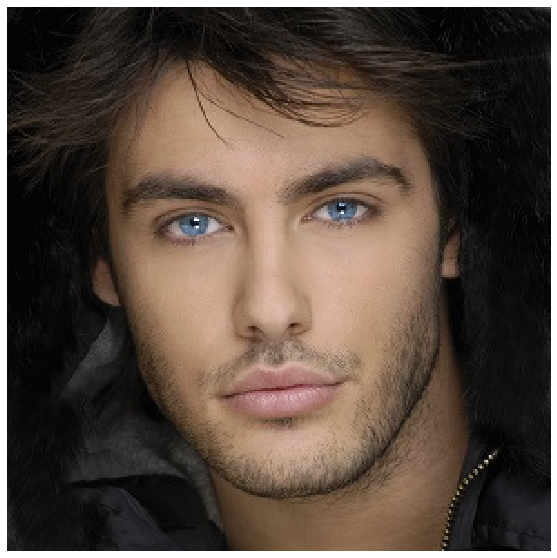

In [19]:
# Read image
image = cv2.imread("Media/M4/Super.jpg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1]);plt.axis('off');

##  <font style="color:rgb(134,19,348)"> Pre-processing the image 
</font>
In the this step we are going to Resize our image to (224x224) and convert it to YCbCr Color format. This format has following color components:

- **Y:**  This is like the grayscale intensity channel, it holds all the image structure.
- **Cb:** This is the blue-difference channel. 
- **Cr:** This is the red difference channel. 

After this we some formating of the Y channel and then finally normalize it by dividing with 255.0.

In [20]:
# Prepare the Image before fed into the network

# Creating Copy of Image
img_copy = image.copy()

# Resize the image into Required Size
img_copy = cv2.resize(img_copy, (224,224), cv2.INTER_CUBIC)

# Convert image into YcbCr
image_YCbCr = cv2.cvtColor(img_copy, cv2.COLOR_BGR2YCrCb)

# Split Y,Cb, and Cr channel 
image_Y, image_Cb, image_Cr = cv2.split(image_YCbCr)

# Convert Y channel into a numpy arrary
img_ndarray = np.asarray(image_Y)

# Reshape the image to (1,1,224,224) 
image_expanded = img_ndarray.reshape(1,1,224,224)

# Convert to float32 and as a normalization step divide the image by 255.0
blob = image_expanded.astype(np.float32) / 255.0

print('initial Shape of Y: {}, Shape After Preprocessing: {}'.format(image_Y.shape, blob.shape))

initial Shape of Y: (224, 224), Shape After Preprocessing: (1, 1, 224, 224)


## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>

In [21]:
# Passing the blob as input through the network 
net.setInput(blob)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [23]:
%%time
Output = net.forward()

Wall time: 95 ms


In [24]:
# Our iamge has been resized to 672, a 3x increase.
print(Output.shape)

(1, 1, 672, 672)


##  <font style="color:rgb(134,19,348)"> Post-processing the image </font> 
We got a 4D matrix as the output, now in the post-processing step you undo the steps you did in preprocessing.

In [25]:
# Reshape the output and get rid of those extra dimensions
reshaped_output = Output.reshape(672,672)

# Get the image back to the range 0-255 from 0-1
reshaped_output = reshaped_output * 255

# Clip the values so the output is it between 0-255
Final_Output = np.clip(reshaped_output, 0, 255)

# Resize the Cb and Cr channel with output dimension
resize_Cb = cv2.resize(image_Cb,(672,672),cv2.INTER_CUBIC)
resized_Cr = cv2.resize(image_Cr,(672,672),cv2.INTER_CUBIC)

# Merge 3 channel together 
Final_Img = cv2.merge((Final_Output.astype('uint8'),resize_Cb,resized_Cr))

# Covert back into BGR channel
Final_Img = cv2.cvtColor(Final_Img,cv2.COLOR_YCR_CB2BGR)
print(Final_Img.shape)

(672, 672, 3)


##  <font style="color:rgb(134,19,348)">Display Final Result 
</font>

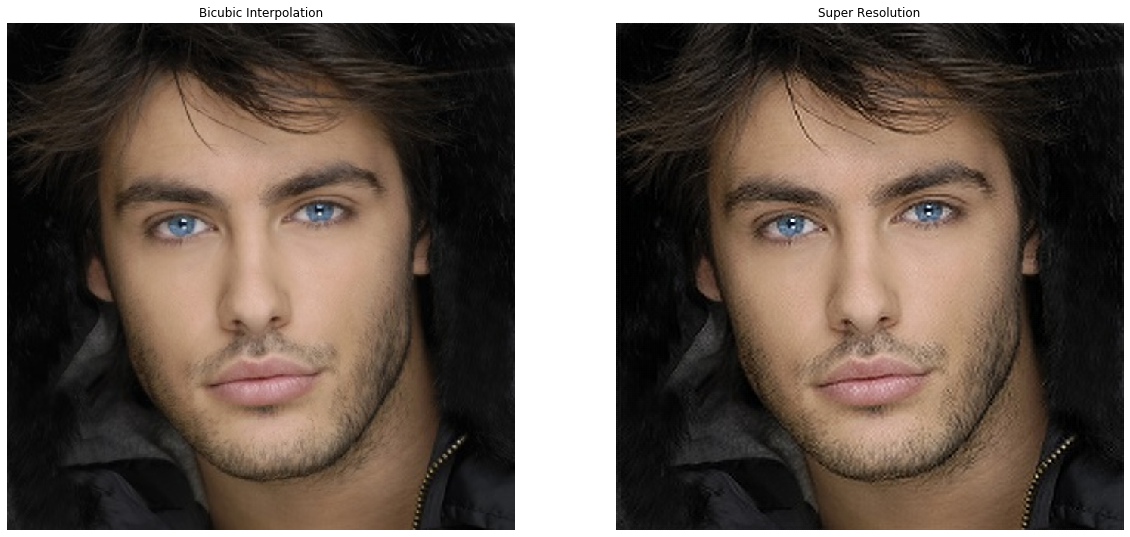

In [26]:
# This is how the image would look with Bicubic interpolation.
image_copy = cv2.resize(image,(672,672), cv2.INTER_CUBIC)

# Display the Bicubic Image and Super Resolution Image
plt.figure(figsize=[20,20])
plt.subplot(1,2,1);plt.imshow(image_copy[:,:,::-1]);plt.title("Bicubic Interpolation");plt.axis("off");
plt.subplot(1,2,2);plt.imshow(Final_Img[:,:,::-1]);plt.title("Super Resolution");plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialize Function </font>
This method will be run once and it will initialize the network with the required files.

In [27]:
def init_superres(usegpu = 'None',model="super_resolution.onnx"):
    
    # Set global variables
    global net
    
    base_path = 'Media/M4/Model'
    
    # Defining model path
    model = os.path.join(base_path, model)    
    
    # Initialize the DNN module
    net = cv2.dnn.readNetFromONNX(model)

    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)    

## <font style="color:rgb(134,19,348)">  Main Function </font>

In [28]:
def super_res(image=[], usercam=False,returndata=False):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
                
        # Otherwise select image from computer using tkinter        
        else:
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
            root.withdraw()
            image = cv2.imread(root.filename)
            
    # Creating Copy of Image
    img_copy = image.copy()

    # Resize the image into Required Size
    img_copy = cv2.resize(img_copy, (224,224), cv2.INTER_CUBIC)

    # Convert image into YcbCr
    image_YCbCr = cv2.cvtColor(img_copy, cv2.COLOR_BGR2YCrCb)

    # Split Y,Cb, and Cr channel 
    image_Y, image_Cb, image_Cr = cv2.split(image_YCbCr)

    # Convert Y channel into a numpy arrary
    img_ndarray = np.asarray(image_Y)

    # Reshape the image to (1,1,224,224) 
    image_expanded = img_ndarray.reshape(1,1,224,224)

    # Convert to float32 and as a normalization step divide the image by 255.0
    blob = image_expanded.astype(np.float32) / 255.0
    
    # Passing the blob as input through the network 
    net.setInput(blob)
    
    # Forward pass
    Output = net.forward()
    
    # Reshape the output and get rid of those extra dimensions
    reshaped_output = Output.reshape(672,672)

    # Get the image back to the range 0-255 from 0-1
    reshaped_output = reshaped_output * 255

    # Clip the values so the output is it between 0-255
    Final_Output = np.clip(reshaped_output, 0, 255)

    # Resize the Cb and Cr channel with output dimension
    resize_Cb = cv2.resize(image_Cb,(672,672),cv2.INTER_CUBIC)
    resized_Cr = cv2.resize(image_Cr,(672,672),cv2.INTER_CUBIC)

    # Merge 3 channel together 
    Final_Img = cv2.merge((Final_Output.astype('uint8'),resize_Cb,resized_Cr))

    # Convert back into BGR channel
    Final_Img = cv2.cvtColor(Final_Img,cv2.COLOR_YCR_CB2BGR)
        
   # This is how the image would look with Bicubic interpolation.
    image_copy = cv2.resize(image,(672,672), cv2.INTER_CUBIC)
    
    # Stack two image together inorder to see the comparision b/w them
    stacked = np.hstack((image_copy, Final_Img))
    
    if  returndata:
        return stacked
    
    else:
        plt.figure(figsize=[20,20])
        plt.subplot(1,2,1);plt.imshow(image_copy[:,:,::-1]);plt.title("Bicubic Interpolation");plt.axis("off");
        plt.subplot(1,2,2);plt.imshow(Final_Img[:,:,::-1]);plt.title("Super Resolution");plt.axis("off");       

**Initialize the Super Resolution**

In [29]:
init_superres()

**Calling Super Resolution with default arguments.**

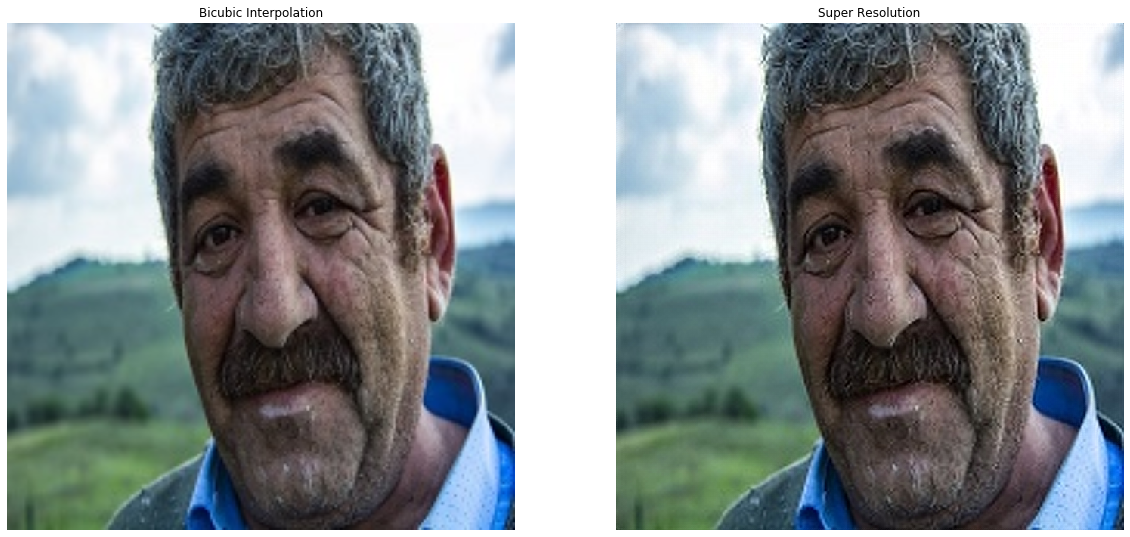

In [30]:
image = cv2.imread("Media/M4/super2.jpg")
super_res(image)

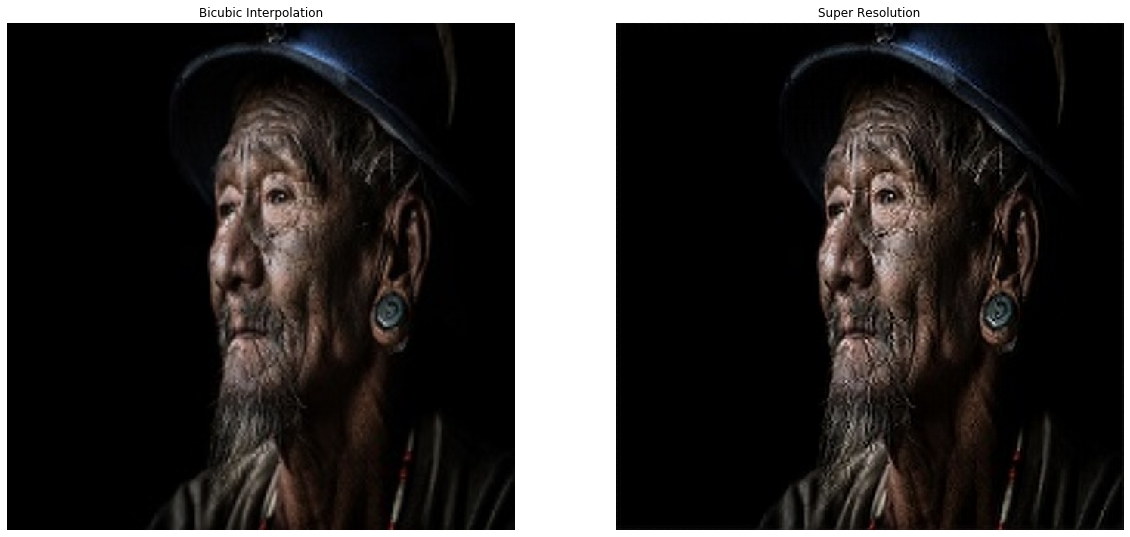

In [31]:
image = cv2.imread("Media/M4/super3.jpg")
super_res(image)

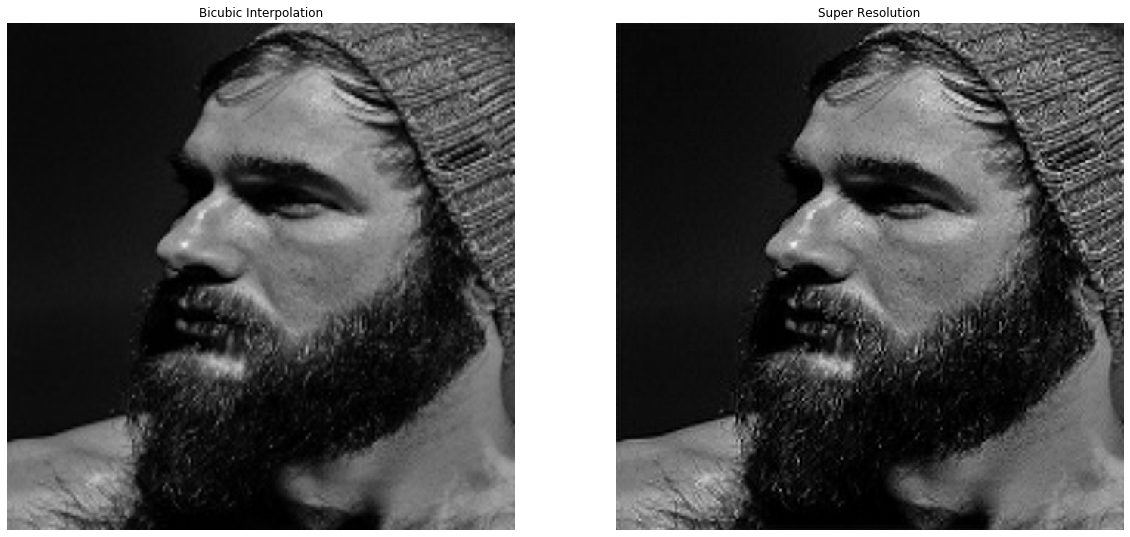

In [32]:
image = cv2.imread("Media/M4/youngman2.jpg")
super_res(image)

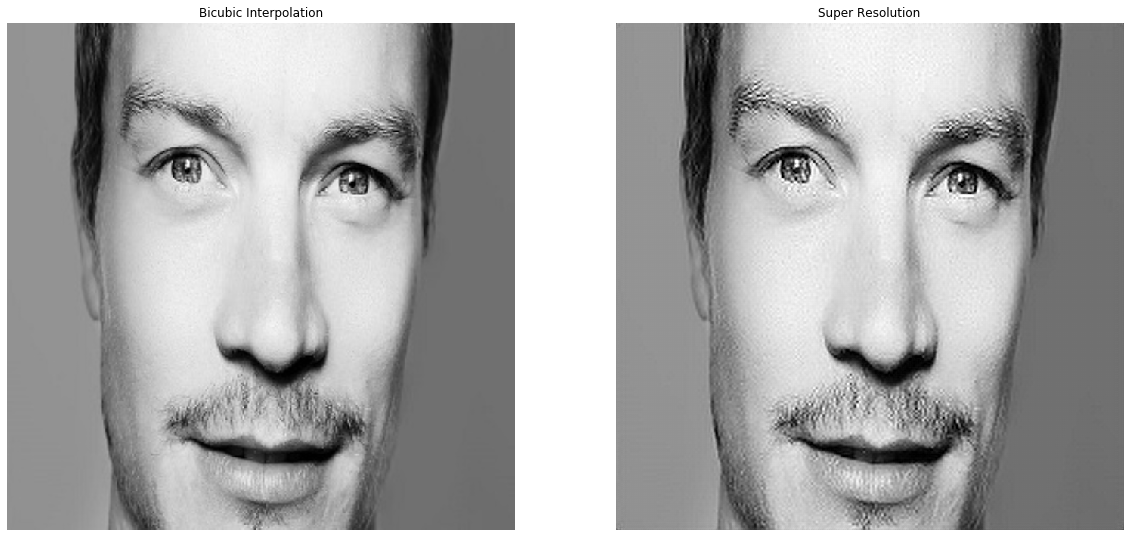

In [33]:
image = cv2.imread("Media/M4/faceman.jpg")
super_res(image)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_superres()

In [ ]:
%%time
image= super_res(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_superres(usegpu = 'opencl')

In [ ]:
%%time
image= super_res(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_superres(usegpu = 'cuda')

In [ ]:
%%time
image= super_res(image = image, returndata=True)

## <font style="color:rgb(134,19,348)"> Super Resolution on Video </font>

In [ ]:
# Initializing method
init_superres()

# Starting video reading mode
cap = cv2.VideoCapture('Media/M4/dpose.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Specifying Video writing path
out = cv2.VideoWriter(r'Media/M4/superes.mp4',fourcc, 20.0, (700,500))

while(True):
    
    ret, frame = cap.read()
    if not ret:
        break
        
    res = super_res(image,returndata=True)
    
    cv2.imshow('Super Resolution',res)
    out.write(res)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()